# Benchmarking full and chunked file reading

In this notebook, a benchmark on three file types (DAT, EVT2 and EVT3) is run 

In [1]:
from expelliarmus import Wizard
import pathlib
import h5py
import numpy as np
import timeit
import requests
import pickle
from metavision_core.event_io import EventsIterator

FIRST_RUN = True
SAVE_RESULTS = True
LOAD_RESULTS = False
REPEAT = 2

In [2]:
def get_diff_perc_str(ref, val):
    if val > ref:
        return f"+{(val/ref-1)*100:.2f}%"
    else:
        return f"-{(1-val/ref)*100:.2f}%"


get_fsize_MB = lambda fpath: round(fpath.stat().st_size / (1024 * 1024))

In [3]:
if FIRST_RUN:
    # Downloading files.
    if not pathlib.Path("./spinner.dat").is_file():
        print("Downloading DAT file...")
        r = requests.get(
            "https://dataset.prophesee.ai/index.php/s/YAri3vpPZHhEZfc/download",
            allow_redirects=True,
        )  # spinner.dat, DAT
        open("./spinner.dat", "wb").write(r.content)
    if not pathlib.Path("./monitoring_40_50hz.raw").is_file():
        print("Downloading EVT2 file...")
        r = requests.get(
            "https://dataset.prophesee.ai/index.php/s/s5DFqzVQhlaU8Y5/download",
            allow_redirects=True,
        )  # monitoring_40_50hz.raw, EVT2
        open("./monitoring_40_50hz.raw", "wb").write(r.content)
    if not pathlib.Path("./driving_sample.raw").is_file():
        print("Downloading EVT3 file...")
        r = requests.get(
            "https://dataset.prophesee.ai/index.php/s/nVcLLdWAnNzrmII/download",
            allow_redirects=True,
        )  # driving_sample.raw, EVT3
        open("./driving_sample.raw", "wb").write(r.content)
    print("Everything downloaded!")
files = ("spinner.dat", "monitoring_40_50hz.raw", "driving_sample.raw")

Everything downloaded!


In [4]:
softwares = ("expelliarmus", "metavision", "hdf5", "hdf5_lzf", "hdf5_gzip", "numpy")
encodings = ("dat", "evt2", "evt3")
metrics = ("fsize", "full_read", "chunk_read")
data = {}
for software in softwares:
    data[software] = {}
    for encoding in encodings:
        data[software][encoding] = {}
        for metric in metrics:
            data[software][encoding][metric] = 0

In [7]:
if LOAD_RESULTS:
    data = pickle.load(open("./benchmark.pk", "rb"))

wizard = Wizard(encoding="dat")
print("=" * 50 + "\nFull file read")
for f, encoding in zip(files, encodings):
    print("=" * 50)

    if not LOAD_RESULTS:
        exp_fpath = pathlib.Path(f)
        hdf5_fpath = pathlib.Path(f"./ref_HDF5_{encoding.upper()}.hdf5")
        hdf5_lzf_fpath = pathlib.Path(f"./ref_HDF5_LZF_{encoding.upper()}.hdf5")
        hdf5_gzip_fpath = pathlib.Path(f"./ref_HDF5_GZIP_{encoding.upper()}.hdf5")
        np_fpath = pathlib.Path(f"./ref_np_{encoding.upper()}.npy")

        wizard.set_encoding(encoding)
        wizard.set_file(exp_fpath)
        if FIRST_RUN:
            arr = wizard.read()
        data["expelliarmus"][encoding]["fsize"] = get_fsize_MB(exp_fpath)

        # Metavision
        data["metavision"][encoding]["fsize"] = get_fsize_MB(exp_fpath)

        # HDF5
        if FIRST_RUN:
            hdf5_fp = h5py.File(hdf5_fpath, "w")
            arr_hdf5 = hdf5_fp.create_dataset("arr", arr.shape, arr.dtype)
            arr_hdf5[:] = arr[:]
            hdf5_fp.close()
        data["hdf5"][encoding]["fsize"] = get_fsize_MB(hdf5_fpath)

        # HDF5 LZF
        if FIRST_RUN:
            hdf5_lzf_fp = h5py.File(hdf5_lzf_fpath, "w")
            arr_hdf5_lzf = hdf5_lzf_fp.create_dataset(
                "arr", arr.shape, arr.dtype, compression="lzf"
            )
            arr_hdf5_lzf[:] = arr[:]
            hdf5_lzf_fp.close()
        data["hdf5_lzf"][encoding]["fsize"] = get_fsize_MB(hdf5_lzf_fpath)

        # HDF5 GZIP
        if FIRST_RUN:
            hdf5_gzip_fp = h5py.File(hdf5_gzip_fpath, "w")
            arr_hdf5_gzip = hdf5_gzip_fp.create_dataset(
                "arr", arr.shape, arr.dtype, compression="gzip"
            )
            arr_hdf5_gzip[:] = arr[:]
            hdf5_gzip_fp.close()
        data["hdf5_gzip"][encoding]["fsize"] = get_fsize_MB(hdf5_gzip_fpath)

        # NumPy
        if FIRST_RUN:
            np.save(np_fpath, arr, allow_pickle=False)
        data["numpy"][encoding]["fsize"] = get_fsize_MB(np_fpath)

        data["expelliarmus"][encoding]["full_read"] = (
            sum(timeit.repeat(lambda: wizard.read(), number=1, repeat=REPEAT)) / REPEAT
        )

        def meta_fn():
            ev_it = EventsIterator(input_path=f)
            return np.concatenate([ev for ev in ev_it])

        data["metavision"][encoding]["full_read"] = (
            sum(timeit.repeat(meta_fn, number=1, repeat=REPEAT)) / REPEAT
        )

        hdf5_fp = h5py.File(hdf5_fpath)
        data["hdf5"][encoding]["full_read"] = (
            sum(timeit.repeat(lambda: hdf5_fp["arr"][:], number=1, repeat=REPEAT))
            / REPEAT
        )
        hdf5_fp.close()

        hdf5_lzf_fp = h5py.File(hdf5_lzf_fpath)
        data["hdf5_lzf"][encoding]["full_read"] = (
            sum(timeit.repeat(lambda: hdf5_lzf_fp["arr"][:], number=1, repeat=REPEAT))
            / REPEAT
        )
        hdf5_lzf_fp.close()

        hdf5_gzip_fp = h5py.File(hdf5_gzip_fpath)
        data["hdf5_gzip"][encoding]["full_read"] = (
            sum(timeit.repeat(lambda: hdf5_gzip_fp["arr"][:], number=1, repeat=REPEAT))
            / REPEAT
        )
        hdf5_gzip_fp.close()

        data["numpy"][encoding]["full_read"] = (
            sum(timeit.repeat(lambda: np.load(np_fpath), number=1, repeat=REPEAT))
            / REPEAT
        )

    print(
        f'{encoding.upper()} ({data["expelliarmus"][encoding]["fsize"]}MB), execution time: {data["expelliarmus"][encoding]["full_read"]:.3f}s.'
    )
    print(
        f'Metavision ({data["metavision"][encoding]["fsize"]}MB), execution time: {data["metavision"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["metavision"][encoding]["full_read"])}'
    )
    print(
        f'HDF5 ({data["hdf5"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5"][encoding]["fsize"])}), execution time: {data["hdf5"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["hdf5"][encoding]["full_read"])}.'
    )
    print(
        f'HDF5 GZIP ({data["hdf5_gzip"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_gzip"][encoding]["fsize"])}), execution time: {data["hdf5_gzip"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["hdf5_gzip"][encoding]["full_read"])}.'
    )
    print(
        f'HDF5 LZF ({data["hdf5_lzf"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_lzf"][encoding]["fsize"])}), execution time: {data["hdf5_lzf"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["hdf5_lzf"][encoding]["full_read"])}.'
    )
    print(
        f'NumPy ({data["numpy"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["numpy"][encoding]["fsize"])}), execution time: {data["numpy"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["numpy"][encoding]["full_read"])}.'
    )

Full file read
DAT (413MB), execution time: 0.346s.
Metavision (413MB), execution time: 2.136s, +517.07%
HDF5 (826MB, +100.00%), execution time: 0.360s, +3.96%.
HDF5 GZIP (163MB, -60.53%), execution time: 2.371s, +584.92%.
HDF5 LZF (316MB, -23.49%), execution time: 1.394s, +302.60%.
NumPy (826MB, +100.00%), execution time: 0.223s, -35.68%.
EVT2 (157MB), execution time: 0.339s.
Metavision (157MB), execution time: 1.181s, +248.21%
HDF5 (621MB, +295.54%), execution time: 0.262s, -22.68%.
HDF5 GZIP (156MB, -0.64%), execution time: 1.980s, +484.08%.
HDF5 LZF (276MB, +75.80%), execution time: 1.168s, +244.58%.
NumPy (621MB, +295.54%), execution time: 0.162s, -52.21%.
EVT3 (350MB), execution time: 1.795s.
Metavision (350MB), execution time: 3.904s, +117.52%
HDF5 (1701MB, +386.00%), execution time: 0.705s, -60.71%.
HDF5 GZIP (419MB, +19.71%), execution time: 5.384s, +199.94%.
HDF5 LZF (746MB, +113.14%), execution time: 2.922s, +62.78%.
NumPy (1701MB, +386.00%), execution time: 0.444s, -75.28%.

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 220
plt.style.use("classic")
%matplotlib inline

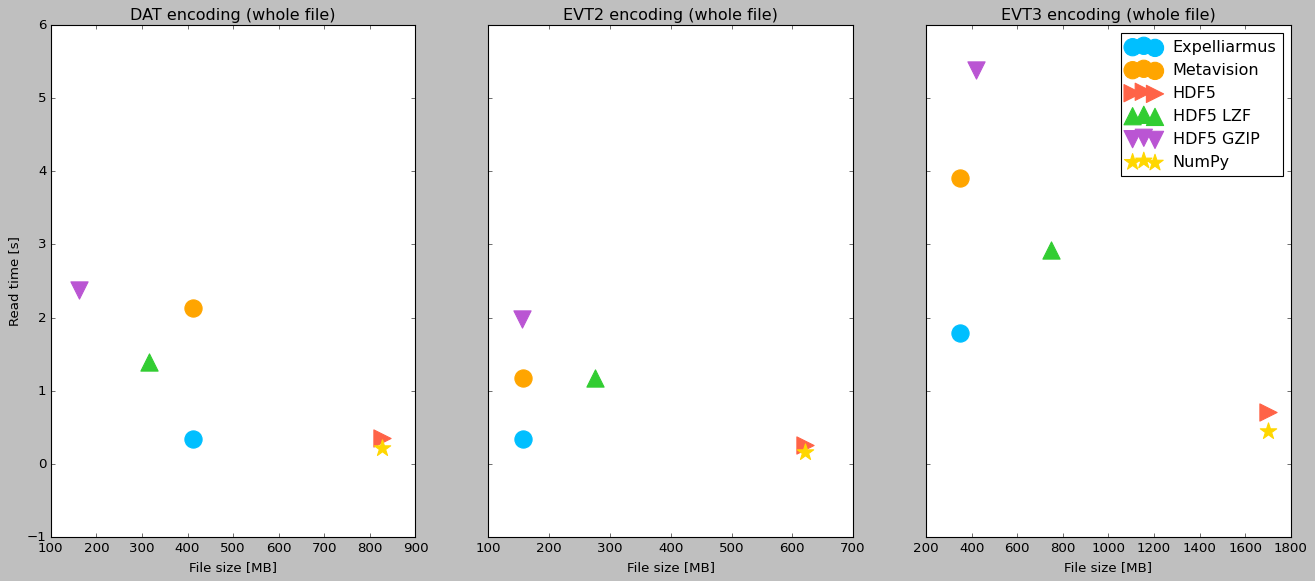

In [15]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 8))

# plt.ylim(bottom=0, top=3.5)
ax0.set_xlabel("File size [MB]")
ax1.set_xlabel("File size [MB]")
ax2.set_xlabel("File size [MB]")

ax0.set_ylabel("Read time [s]")

ax0.set_title("DAT encoding (whole file)")
ax1.set_title("EVT2 encoding (whole file)")
ax2.set_title("EVT3 encoding (whole file)")

# Expelliarmus
ax0.scatter(
    data["expelliarmus"]["dat"]["fsize"],
    data["expelliarmus"]["dat"]["full_read"],
    marker="o",
    s=240,
    color="deepskyblue",
    label="Expelliarmus",
)
ax1.scatter(
    data["expelliarmus"]["evt2"]["fsize"],
    data["expelliarmus"]["evt2"]["full_read"],
    marker="o",
    s=240,
    color="deepskyblue",
)
exp = ax2.scatter(
    data["expelliarmus"]["evt3"]["fsize"],
    data["expelliarmus"]["evt3"]["full_read"],
    marker="o",
    s=240,
    color="deepskyblue",
)

# Metavision
ax0.scatter(
    data["metavision"]["dat"]["fsize"],
    data["metavision"]["dat"]["full_read"],
    marker="o",
    s=240,
    color="orange",
    label="Metavision",
)
ax1.scatter(
    data["metavision"]["evt2"]["fsize"],
    data["metavision"]["evt2"]["full_read"],
    marker="o",
    s=240,
    color="orange",
)
met = ax2.scatter(
    data["metavision"]["evt3"]["fsize"],
    data["metavision"]["evt3"]["full_read"],
    marker="o",
    s=240,
    color="orange",
)

# HDF5
ax0.scatter(
    data["hdf5"]["dat"]["fsize"],
    data["hdf5"]["dat"]["full_read"],
    marker=">",
    s=240,
    color="tomato",
    label="HDF5",
)
ax1.scatter(
    data["hdf5"]["evt2"]["fsize"],
    data["hdf5"]["evt2"]["full_read"],
    marker=">",
    s=240,
    color="tomato",
)
hdf5 = ax2.scatter(
    data["hdf5"]["evt3"]["fsize"],
    data["hdf5"]["evt3"]["full_read"],
    marker=">",
    s=240,
    color="tomato",
)

# HDF5 LZF
ax0.scatter(
    data["hdf5_lzf"]["dat"]["fsize"],
    data["hdf5_lzf"]["dat"]["full_read"],
    marker="^",
    s=240,
    color="limegreen",
    label="HDF5 LZF",
)
ax1.scatter(
    data["hdf5_lzf"]["evt2"]["fsize"],
    data["hdf5_lzf"]["evt2"]["full_read"],
    marker="^",
    s=240,
    color="limegreen",
)
hdf5_lzf = ax2.scatter(
    data["hdf5_lzf"]["evt3"]["fsize"],
    data["hdf5_lzf"]["evt3"]["full_read"],
    marker="^",
    s=240,
    color="limegreen",
)

# HDF5 GZIP
ax0.scatter(
    data["hdf5_gzip"]["dat"]["fsize"],
    data["hdf5_gzip"]["dat"]["full_read"],
    marker="v",
    s=240,
    color="mediumorchid",
    label="HDF5 GZIP",
)
ax1.scatter(
    data["hdf5_gzip"]["evt2"]["fsize"],
    data["hdf5_gzip"]["evt2"]["full_read"],
    marker="v",
    s=240,
    color="mediumorchid",
)
hdf5_gzip = ax2.scatter(
    data["hdf5_gzip"]["evt3"]["fsize"],
    data["hdf5_gzip"]["evt3"]["full_read"],
    marker="v",
    s=240,
    color="mediumorchid",
)

# NumPy
ax0.scatter(
    data["numpy"]["dat"]["fsize"],
    data["numpy"]["dat"]["full_read"],
    marker="*",
    s=240,
    color="gold",
    label="NumPy",
)
ax1.scatter(
    data["numpy"]["evt2"]["fsize"],
    data["numpy"]["evt2"]["full_read"],
    marker="*",
    s=240,
    color="gold",
)
npy = ax2.scatter(
    data["numpy"]["evt3"]["fsize"],
    data["numpy"]["evt3"]["full_read"],
    marker="*",
    s=240,
    color="gold",
)

plt.legend(
    (exp, met, hdf5, hdf5_lzf, hdf5_gzip, npy),
    ("Expelliarmus", "Metavision", "HDF5", "HDF5 LZF", "HDF5 GZIP", "NumPy"),
    loc="upper right",
)
plt.show()

In [10]:
CHUNK_SIZE = 8192
print("\n" + "=" * 50 + "\nChunk reading.")
for f, encoding in zip(files, encodings):
    print("=" * 50)

    if not LOAD_RESULTS:
        arr_len = len(np.load(f"ref_np_{encoding.upper()}.npy"))
        exp_fpath = pathlib.Path(f)
        hdf5_fpath = pathlib.Path(f"./ref_HDF5_{encoding.upper()}.hdf5")
        hdf5_lzf_fpath = pathlib.Path(f"./ref_HDF5_LZF_{encoding.upper()}.hdf5")
        hdf5_gzip_fpath = pathlib.Path(f"./ref_HDF5_GZIP_{encoding.upper()}.hdf5")

        wizard.set_encoding(encoding)
        wizard.set_file(exp_fpath)
        wizard.set_chunk_size(CHUNK_SIZE)

        def fn():
            wizard.reset()
            return [chunk for chunk in wizard.read_chunk()]

        data["expelliarmus"][encoding]["chunk_read"] = (
            sum(timeit.repeat(fn, number=1, repeat=REPEAT)) / REPEAT
        )

        def meta_fn():
            ev_it = EventsIterator(f)
            return [ev for ev in ev_it]

        data["metavision"][encoding]["chunk_read"] = (
            sum(timeit.repeat(meta_fn, number=1, repeat=REPEAT)) / REPEAT
        )

        hdf5_fp = h5py.File(hdf5_fpath)
        data["hdf5"][encoding]["chunk_read"] = (
            sum(
                timeit.repeat(
                    lambda: [
                        hdf5_fp["arr"][
                            i * CHUNK_SIZE : min(arr_len, (i + 1) * CHUNK_SIZE)
                        ]
                        for i in range(arr_len // CHUNK_SIZE)
                    ],
                    number=1,
                    repeat=REPEAT,
                )
            )
            / REPEAT
        )

        hdf5_lzf_fp = h5py.File(hdf5_lzf_fpath)
        data["hdf5_lzf"][encoding]["chunk_read"] = (
            sum(
                timeit.repeat(
                    lambda: [
                        hdf5_lzf_fp["arr"][
                            i * CHUNK_SIZE : min(arr_len, (i + 1) * CHUNK_SIZE)
                        ]
                        for i in range(arr_len // CHUNK_SIZE)
                    ],
                    number=1,
                    repeat=REPEAT,
                )
            )
            / REPEAT
        )

        hdf5_gzip_fp = h5py.File(hdf5_gzip_fpath)
        data["hdf5_gzip"][encoding]["chunk_read"] = (
            sum(
                timeit.repeat(
                    lambda: [
                        hdf5_gzip_fp["arr"][
                            i * CHUNK_SIZE : min(arr_len, (i + 1) * CHUNK_SIZE)
                        ]
                        for i in range(arr_len // CHUNK_SIZE)
                    ],
                    number=1,
                    repeat=REPEAT,
                )
            )
            / REPEAT
        )

        hdf5_fp.close()
        hdf5_lzf_fp.close()
        hdf5_gzip_fp.close()

    print(
        f'{encoding.upper()} ({data["expelliarmus"][encoding]["fsize"]}MB), execution time: {data["expelliarmus"][encoding]["chunk_read"]:.3f}s.'
    )
    print(
        f'Metavision ({data["metavision"][encoding]["fsize"]}MB), execution time: {data["metavision"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["metavision"][encoding]["chunk_read"])}.'
    )
    print(
        f'HDF5 ({data["hdf5"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5"][encoding]["fsize"])}), execution time: {data["hdf5"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["hdf5"][encoding]["chunk_read"])}.'
    )
    print(
        f'HDF5 LZF ({data["hdf5_lzf"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_lzf"][encoding]["fsize"])}), execution time: {data["hdf5_lzf"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["hdf5_lzf"][encoding]["chunk_read"])}.'
    )
    print(
        f'HDF5 GZIP ({data["hdf5_gzip"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_gzip"][encoding]["fsize"])}), execution time: {data["hdf5_gzip"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["hdf5_gzip"][encoding]["chunk_read"])}.'
    )


Chunk reading.
DAT (413MB), execution time: 0.676s.
Metavision (413MB), execution time: 1.907s, +182.07%.
HDF5 (826MB, +100.00%), execution time: 1.945s, +187.70%.
HDF5 LZF (316MB, -23.49%), execution time: 4.151s, +514.06%.
HDF5 GZIP (163MB, -60.53%), execution time: 5.565s, +723.13%.
EVT2 (157MB), execution time: 0.340s.
Metavision (157MB), execution time: 0.575s, +69.08%.
HDF5 (621MB, +295.54%), execution time: 1.445s, +324.92%.
HDF5 LZF (276MB, +75.80%), execution time: 3.813s, +1021.46%.
HDF5 GZIP (156MB, -0.64%), execution time: 5.552s, +1533.00%.
EVT3 (350MB), execution time: 1.987s.
Metavision (350MB), execution time: 2.490s, +25.30%.
HDF5 (1701MB, +386.00%), execution time: 4.209s, +111.82%.
HDF5 LZF (746MB, +113.14%), execution time: 10.396s, +423.16%.
HDF5 GZIP (419MB, +19.71%), execution time: 16.725s, +741.69%.


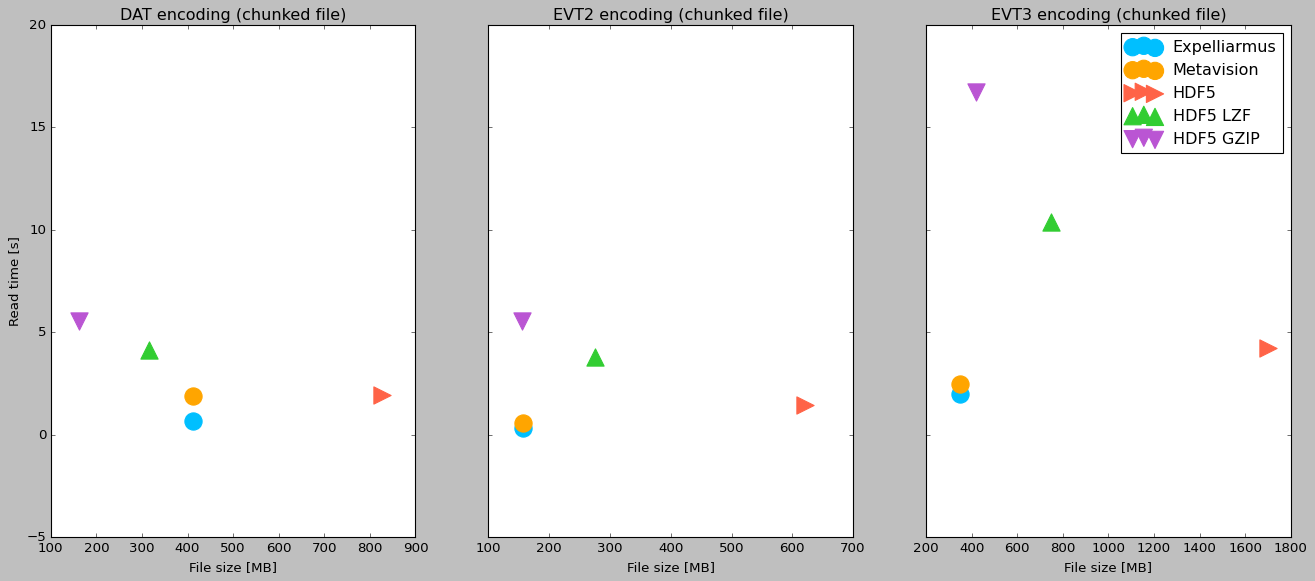

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 8))

# plt.ylim(bottom=0, top=3.5)
ax0.set_xlabel("File size [MB]")
ax1.set_xlabel("File size [MB]")
ax2.set_xlabel("File size [MB]")

ax0.set_ylabel("Read time [s]")

ax0.set_title("DAT encoding (chunked file)")
ax1.set_title("EVT2 encoding (chunked file)")
ax2.set_title("EVT3 encoding (chunked file)")

# Expelliarmus
ax0.scatter(
    data["expelliarmus"]["dat"]["fsize"],
    data["expelliarmus"]["dat"]["chunk_read"],
    marker="o",
    s=240,
    color="deepskyblue",
    label="Expelliarmus",
)
ax1.scatter(
    data["expelliarmus"]["evt2"]["fsize"],
    data["expelliarmus"]["evt2"]["chunk_read"],
    marker="o",
    s=240,
    color="deepskyblue",
)
exp = ax2.scatter(
    data["expelliarmus"]["evt3"]["fsize"],
    data["expelliarmus"]["evt3"]["chunk_read"],
    marker="o",
    s=240,
    color="deepskyblue",
)

# Metavision
ax0.scatter(
    data["metavision"]["dat"]["fsize"],
    data["metavision"]["dat"]["chunk_read"],
    marker="o",
    s=240,
    color="orange",
    label="Metavision",
)
ax1.scatter(
    data["metavision"]["evt2"]["fsize"],
    data["metavision"]["evt2"]["chunk_read"],
    marker="o",
    s=240,
    color="orange",
)
met = ax2.scatter(
    data["metavision"]["evt3"]["fsize"],
    data["metavision"]["evt3"]["chunk_read"],
    marker="o",
    s=240,
    color="orange",
)

# HDF5
ax0.scatter(
    data["hdf5"]["dat"]["fsize"],
    data["hdf5"]["dat"]["chunk_read"],
    marker=">",
    s=240,
    color="tomato",
    label="HDF5",
)
ax1.scatter(
    data["hdf5"]["evt2"]["fsize"],
    data["hdf5"]["evt2"]["chunk_read"],
    marker=">",
    s=240,
    color="tomato",
)
hdf5 = ax2.scatter(
    data["hdf5"]["evt3"]["fsize"],
    data["hdf5"]["evt3"]["chunk_read"],
    marker=">",
    s=240,
    color="tomato",
)

# HDF5 LZF
ax0.scatter(
    data["hdf5_lzf"]["dat"]["fsize"],
    data["hdf5_lzf"]["dat"]["chunk_read"],
    marker="^",
    s=240,
    color="limegreen",
    label="HDF5 LZF",
)
ax1.scatter(
    data["hdf5_lzf"]["evt2"]["fsize"],
    data["hdf5_lzf"]["evt2"]["chunk_read"],
    marker="^",
    s=240,
    color="limegreen",
)
hdf5_lzf = ax2.scatter(
    data["hdf5_lzf"]["evt3"]["fsize"],
    data["hdf5_lzf"]["evt3"]["chunk_read"],
    marker="^",
    s=240,
    color="limegreen",
)

# HDF5 GZIP
ax0.scatter(
    data["hdf5_gzip"]["dat"]["fsize"],
    data["hdf5_gzip"]["dat"]["chunk_read"],
    marker="v",
    s=240,
    color="mediumorchid",
    label="HDF5 GZIP",
)
hdf5_gzip = ax1.scatter(
    data["hdf5_gzip"]["evt2"]["fsize"],
    data["hdf5_gzip"]["evt2"]["chunk_read"],
    marker="v",
    s=240,
    color="mediumorchid",
)
hdf5_gzip = ax2.scatter(
    data["hdf5_gzip"]["evt3"]["fsize"],
    data["hdf5_gzip"]["evt3"]["chunk_read"],
    marker="v",
    s=240,
    color="mediumorchid",
)

plt.legend(
    (exp, met, hdf5, hdf5_lzf, hdf5_gzip),
    ("Expelliarmus", "Metavision", "HDF5", "HDF5 LZF", "HDF5 GZIP"),
    loc="upper right",
)
plt.show()

In [12]:
if SAVE_RESULTS:
    pickle.dump(data, open("./benchmark.pk", "wb"))